# Analysis of pairwise k-mer Jaccard Similarity - 50 Ecoli genomes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline


In [2]:
import screed

In [3]:
import mmh3

In [4]:
# https://github.com/ipython/ipython/issues/10627
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [5]:

# import ete3 as ETE

# from ete3 import Tree

In [6]:

import ete3 as ETE

from ete3 import Tree

## Define paths to sample metadata files & key directories

In [7]:

Proj_MainDir = "/n/data1/hms/dbmi/farhat/mm774/Projects"

Ecoli_PG_MainDir = f"{Proj_MainDir}/230905_Ecoli_PG_Analysis"  

Data_MainDir = f"{Ecoli_PG_MainDir}/Data"  

Shaw2021_50Asm_Dir = f"{Data_MainDir}/Shaw2021.50Genomes.Data/data"

Shaw2021_Meta_TSV = f"{Data_MainDir}/Shaw2021.SelectedIsolates.50I.tsv"  

input_FA_PATH_TSVs_Dir = f"{Ecoli_PG_MainDir}/input_PATH_SMK_TSVs"

Ecoli_Meta_Dir = f"../../Data/230905_Ecoli_50CI_Metadata_Shaw2021"  

Shaw2021_Ecoli_50Asm_Meta_TSV = f"{Ecoli_Meta_Dir}/231011.Shaw2021.Ecoli.50I.MetaData.tsv"


## Parse in metadata DFs

In [8]:
Shaw_50A_Info_DF = pd.read_csv(Shaw2021_Ecoli_50Asm_Meta_TSV, sep = "\t")
Shaw_50A_Info_DF.shape

(50, 24)

### Define list of SampleIDs

In [9]:
Shaw_50A_Info_DF.head(1)  

,Isolate,Biosample Accession,Short Reads Accession,Long Reads Accession,Assembly Accession,Animal or WwTW,Isolate source information,Timepoint,Niche,Niche.2,...,Circularised plasmids,Number of contigs,Circularised chromosome (1=yes),Total genome size (bp),Chromosome GC (if known),Phylogroup (E. coli only),Alternative isolate name,Long read sequencing method,SampleID,Genome_ASM_PATH
0,RH02|T1-C02,SAMN15147960,SRR11948863,SRR12299015,GCA_014109125.1,Animal,Pooled pig faecal samples collected from floor...,1,Pig,Faeces,...,1,2,1,4953790,50.7,A,RHB02-C02,PacBio,GCA_014109125,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...


In [10]:
E50I_SampleIDs = Shaw_50A_Info_DF["SampleID"].values   
len(E50I_SampleIDs)

50

### Create lineage mapping for sampleIDs

In [11]:
ID_To_Lineage_Dict = dict(Shaw_50A_Info_DF[['SampleID', 'Phylogroup (E. coli only)']].values)


In [12]:
Shaw_50A_Info_DF["Phylogroup (E. coli only)"].value_counts().index.sort_values()

Index(['A', 'B1', 'B2', 'C', 'D', 'E', 'F', 'G', 'cladeV'], dtype='object')

In [13]:
Shaw_50A_Info_DF.head(5)

,Isolate,Biosample Accession,Short Reads Accession,Long Reads Accession,Assembly Accession,Animal or WwTW,Isolate source information,Timepoint,Niche,Niche.2,...,Circularised plasmids,Number of contigs,Circularised chromosome (1=yes),Total genome size (bp),Chromosome GC (if known),Phylogroup (E. coli only),Alternative isolate name,Long read sequencing method,SampleID,Genome_ASM_PATH
0,RH02|T1-C02,SAMN15147960,SRR11948863,SRR12299015,GCA_014109125.1,Animal,Pooled pig faecal samples collected from floor...,1,Pig,Faeces,...,1,2,1,4953790,50.7,A,RHB02-C02,PacBio,GCA_014109125,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...
1,RH02|T1-C06,SAMN15147963,SRR11948664,SRR12298958,GCA_014109065.1,Animal,Pooled pig faecal samples collected from floor...,1,Pig,Faeces,...,1,2,1,4950024,50.7,A,RHB02-C06,Nanopore,GCA_014109065,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...
2,RH02|T1-C10,SAMN15147965,SRR11949072,SRR12298585,GCA_013923405.1,Animal,Pooled pig faecal samples collected from floor...,1,Pig,Faeces,...,1,2,1,4951893,50.7,A,RHB02-C10,PacBio,GCA_013923405,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...
3,RH10|T3-C14,SAMN15148305,SRR11949198,SRR12298645,GCA_013821965.1,Animal,Pooled cattle faecal samples collected from fl...,3,Cattle,Faeces,...,3,4,1,4914446,50.9,A,RHB31-C14,Nanopore,GCA_013821965,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...
4,RH13|T3-C18,SAMN15148321,SRR11949196,SRR12298627,GCA_013819985.1,Animal,Pooled sheep faecal samples collected from flo...,3,Sheep,Faeces,...,3,4,1,4947025,50.8,B1,RHB32-C18,Nanopore,GCA_013819985,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...


In [14]:
Shaw_50A_Info_DF.tail(5)

,Isolate,Biosample Accession,Short Reads Accession,Long Reads Accession,Assembly Accession,Animal or WwTW,Isolate source information,Timepoint,Niche,Niche.2,...,Circularised plasmids,Number of contigs,Circularised chromosome (1=yes),Total genome size (bp),Chromosome GC (if known),Phylogroup (E. coli only),Alternative isolate name,Long read sequencing method,SampleID,Genome_ASM_PATH
45,RH04|T1-C23,SAMN15148116,SRR11948654,SRR12298597,GCA_013898775.1,Animal,Pooled pig faecal samples collected from floor...,1,Pig,Faeces,...,5,6,1,5203607,50.8,G,RHB14-C23,Nanopore,GCA_013898775,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...
46,RH04|T2-C22,SAMN15148265,SRR11949402,SRR12298761,GCA_013830785.1,Animal,Pooled pig faecal samples collected from floor...,2,Pig,Faeces,...,5,6,1,5754742,50.7,G,RHB27-C22,Nanopore,GCA_013830785,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...
47,RH12|T3-C04,SAMN15148434,SRR11949151,SRR12298532,GCA_013800125.1,Animal,Pooled sheep faecal samples collected from flo...,3,Sheep,Faeces,...,6,7,1,4937796,50.7,G,RHB42-C04,Nanopore,GCA_013800125,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...
48,WTP4|T3-00788,SAMN15148698,SRR11948877,SRR12298616,GCA_014103195.1,WTP,Freshwater sample from upstream of wastewater ...,3,WTP4,Upstream,...,1,257,0,5328374,NaN,G,RHBSTW-00788,Nanopore,GCA_014103195,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...
49,RH03|T1-C14,SAMN15148098,SRR11949103,SRR12298967,GCA_013602835.1,Animal,Pooled pig faecal samples collected from floor...,1,Pig,Faeces,...,10,12,1,5193338,51.0,G,RHB13-C14,Nanopore,GCA_013602835,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...


### Create color mapping for sampleIDs (Based on phylo-lineage)

In [15]:
# Dictionary for lineage to color mapping
LinToColor_Dict = {
    "A": "#DF83AC",
    "B1": "#7098CB",
    "B2": "#815D9F",
    "C": "#E76956",
    "D": "#B67548",
    "E": "green",
    "F": "#6AB79E",
    "G": "#E4515B",
    "cladeV": "pur",
    "None": "black",
}

LinToColor_Dict = {
    "A": "#3BAF9F",  # Teal
    "B1": "#9DB17C",  # Light Olive Green
    "B2": "#D2A679",  # Earthy Ochre
    "C": "#9E9AC8",  # Soft Lavender
    "D": "#F88379",  # Coral Pink
    "E": "#BFFF00",  # Bright Lime Green
    "F": "#87CEEB",  # Sky Blue
    "G": "#800020",  # Muted Burgundy
    "cladeV": "#FFA500",  # Orange
    "None": "black",  # Default for undefined categories
}

# Extracting the mapping between IsolateID and PrimaryLineage_Ill
lineage_mapping = Shaw_50A_Info_DF.set_index('SampleID')['Phylogroup (E. coli only)'].to_dict()

# Creating a color mapping for the samples
sample_colors = {sample: LinToColor_Dict.get(lineage, "black") for sample, lineage in lineage_mapping.items()}

ID_To_PrimLineage_Dict = lineage_mapping


In [16]:
#ID_To_PrimLineage_Dict

### Look at lineage distribution across dataset

In [17]:
Shaw_50A_Info_DF["Phylogroup (E. coli only)"].value_counts()

C         7
B1        6
D         6
E         6
F         6
G         6
cladeV    5
A         4
B2        4
Name: Phylogroup (E. coli only), dtype: int64

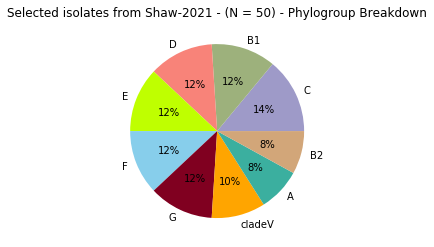

In [18]:
# https://www.statology.org/seaborn-pie-chart/

#define data
data = Shaw_50A_Info_DF["Phylogroup (E. coli only)"].value_counts().values
labels = Shaw_50A_Info_DF["Phylogroup (E. coli only)"].value_counts().index

#define Seaborn color palette to use
#colors = sns.color_palette('pastel')[0:5]

colors_for_labels = [ LinToColor_Dict[label] for label in labels]


#create pie chart
plt.title("Selected isolates from Shaw-2021 - (N = 50) - Phylogroup Breakdown")
plt.pie(data, labels = labels, colors = colors_for_labels, autopct='%.0f%%')
plt.show()


In [19]:
data

array([7, 6, 6, 6, 6, 6, 5, 4, 4])

In [20]:
labels

Index(['C', 'B1', 'D', 'E', 'F', 'G', 'cladeV', 'A', 'B2'], dtype='object')

# Define output dir of the Mtb-WGA-SMK processing pipeline

In [21]:
!ls -1 $Ecoli_PG_MainDir/

Data
input_PATH_SMK_TSVs
SMK_OutDirs


In [22]:
# Define varaint calling pipeline output directories

WGA_SMK_Outputs_Dir = f"{Ecoli_PG_MainDir}/SMK_OutDirs"

PG_Ecoli_50I_OutDir = WGA_SMK_Outputs_Dir + "/231011_Ecoli_Shaw2021_5OI_V1"


In [23]:
target_OutputDir = PG_Ecoli_50I_OutDir

i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"


## Parse IQ-Tree phylogeny

In [24]:
Phylos_OutDir = f"{target_OutputDir}/Phylogenies"

IQTree_OutDir = f"{Phylos_OutDir}/iqtree"

IQ_Tree_MP_PATH = f"{IQTree_OutDir}/Panaroo.Strict.MergeParalogs.MidRoot.WiNodeNames.newick"    


In [25]:
IQ_Tree_MP = Tree(IQ_Tree_MP_PATH, format = 1)


In [26]:
# Count the number of nodes after midpoint rooting
num_nodes = len(IQ_Tree_MP.get_leaves()) + len([node for node in IQ_Tree_MP.traverse() if not node.is_leaf()])

print(num_nodes)

99


### Add lineage info to tree and sort by sub-lineage

In [27]:
count = 0
for n in IQ_Tree_MP.get_leaves():

    if "Bakta" in n.name:
        n.name = n.name.split(".")[0]
    
    n.add_feature("Primary_lineage", ID_To_PrimLineage_Dict.get(n.name, "Unknown Lineage") )

    count +=1

print(count)  
IQ_Tree_MP.sort_descendants(attr='Primary_lineage')


50


## Parsing over each node of the tree (ETE3) and infer lineage

In [28]:
IQ_node_To_PrimaryLin_Dict = {}

for node in IQ_Tree_MP.iter_descendants("postorder"):
    # Do some analysis on node
    
    #print(node.name)
    listOf_ChildLineages = []
    
    for child_node in node.get_descendants():
        if child_node.is_leaf():
            listOf_ChildLineages.append(  (child_node.Primary_lineage) )
        
        #print(node.name, listOf_ChildLineages)
        
    set_Of_ChildLineages = list(set(listOf_ChildLineages))

    #print(node.name, set_Of_ChildLineages  )
    
    if len(set_Of_ChildLineages) == 1:
        OnlyOneLineage = True
    else:
        OnlyOneLineage = False
    
    if OnlyOneLineage:
        IQ_node_To_PrimaryLin_Dict[node.name] = set_Of_ChildLineages[0]

IQ_node_To_PrimaryLin_Dict.update(ID_To_PrimLineage_Dict)
    

## Output "node_To_PrimaryLin_Dict" dictionary 

In [29]:
import json 

!mkdir PhyloInfo/
IQ_NodeToPriLineage_Dict_JSON = f"{IQTree_OutDir}/IQTrees.NodeToPrimaryLineage.json"

with open(IQ_NodeToPriLineage_Dict_JSON, 'w') as json_file:
    json.dump(IQ_node_To_PrimaryLin_Dict, json_file)


mkdir: cannot create directory ‘PhyloInfo/’: File exists


#### test reading back in the JSON

In [30]:
with open(IQ_NodeToPriLineage_Dict_JSON) as json_file:
    IQ_node_To_PrimaryLin_Dict = json.load(json_file)

In [31]:
len(list(IQ_node_To_PrimaryLin_Dict.keys()))

90

### Link to ETE3 documentation for tree layout style
 http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#interactive-visualization-of-trees

In [32]:

node_To_PrimaryLin_Dict= IQ_node_To_PrimaryLin_Dict
def ColorBranchByLineage_Layout(node):
    F = ETE.TextFace(node.name, fsize=2)
    if node.is_leaf():
        #NameAnd_Lineage_Text =  f"  {node.name} {node.Mtb_lineage}"
        #F_NameAndLineage = ETE.TextFace(NameAnd_Lineage_Text, fsize=3)
        
        #ETE.add_face_to_node(F_NameAndLineage, node, column=0, position="branch-right")

        
        nstyle = ETE.NodeStyle() # http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#node-style
        nstyle["fgcolor"] = "black"
        nstyle["size"] = 1
        
        Node_PrimaryLin = node_To_PrimaryLin_Dict.get(node.name, "None")
        
        nstyle["vt_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        nstyle["hz_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
          
        node.set_style(nstyle)
        node.margin_left = 10        
    else: 
        nstyle = ETE.NodeStyle() # http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#node-style
        nstyle["fgcolor"] = "black"
        nstyle["size"] = 0
        
        Node_PrimaryLin = node_To_PrimaryLin_Dict.get(node.name, "None")
        
        nstyle["vt_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        nstyle["hz_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        
        node.set_style(nstyle)


ts_1 = ETE.TreeStyle()
ts_1.show_leaf_name = False
ts_1.show_branch_length = False
ts_1.show_branch_support = False
ts_1.show_scale = False #True
#ts_1.branch_vertical_margin = 2
ts_1.layout_fn = ColorBranchByLineage_Layout
ts_1.rotation = 90


ts_3 = ETE.TreeStyle()
ts_3.show_leaf_name = False
ts_3.show_branch_length = False
ts_3.show_branch_support = False
ts_3.show_scale = True #True
ts_3.branch_vertical_margin = 2
ts_3.layout_fn = ColorBranchByLineage_Layout
ts_3.rotation = 90
ts_3.scale_length = 0.02

ts_3_circ = ETE.TreeStyle()
ts_3_circ.mode = "c" # draw tree in circular mode
ts_3_circ.arc_start = 0 #-180 # 0 degrees = 3 o'clock
ts_3_circ.arc_span = 270
ts_3_circ.show_leaf_name = False
ts_3_circ.show_branch_length = False
ts_3_circ.show_branch_support = False
ts_3_circ.show_scale = False #True
ts_3_circ.branch_vertical_margin = 2
ts_3_circ.layout_fn = ColorBranchByLineage_Layout


## Visualize IQ-Tree Phylogeny

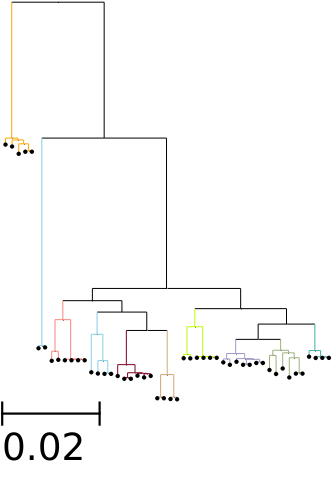

In [33]:
IQ_Tree_MP.render("%%inline", h = 500, tree_style = ts_3)

In [34]:
!mkdir Results5_Plots/

mkdir: cannot create directory ‘Results5_Plots/’: File exists


In [35]:
Z = IQ_Tree_MP.render("Results5_Plots/6.Ecoli50CI.RectPhylo.png", w = 1000, tree_style = ts_3)     

In [36]:
Z = IQ_Tree_MP.render("Results5_Plots/6.Ecoli50CI.RectPhylo.svg", w = 1000, tree_style = ts_3)    

In [37]:
OrderOfSampleIDs_Phylo = [ n.name for n in IQ_Tree_MP.get_leaves() ]  

In [38]:
print(OrderOfSampleIDs_Phylo)

['GCA_013923405', 'GCA_014109125', 'GCA_014109065', 'GCA_013821965', 'GCA_013895455', 'GCA_013899665', 'GCA_013783465', 'GCA_013891895', 'GCA_013752075', 'GCA_013819985', 'GCA_013712565', 'GCA_013713325', 'GCA_013899205', 'GCA_013898935', 'GCA_013894775', 'GCA_013752295', 'GCA_013750375', 'GCA_013806525', 'GCA_013806085', 'GCA_013806925', 'GCA_013886475', 'GCA_013817865', 'GCA_013835405', 'GCA_013924285', 'GCA_013928845', 'GCA_013796065', 'GCA_013782445', 'GCA_013830785', 'GCA_014103195', 'GCA_013800125', 'GCA_013898775', 'GCA_013898995', 'GCA_013602835', 'GCA_013836945', 'GCA_013823125', 'GCA_013900245', 'GCA_013790245', 'GCA_013897255', 'GCA_013896775', 'GCA_013897665', 'GCA_013896515', 'GCA_013786125', 'GCA_013728735', 'GCA_013817505', 'GCA_013894235', 'GCA_013746655', 'GCA_014103465', 'GCA_013732895', 'GCA_013745515', 'GCA_014103665']


In [39]:
Ecoli_MetaTrim_DF = Shaw_50A_Info_DF[["SampleID", "Phylogroup (E. coli only)"] ]
Ecoli_MetaTrim_DF.columns = ["SampleID", "Phylogroup"]
Ecoli_MetaTrim_DF.head()

,SampleID,Phylogroup
0,GCA_014109125,A
1,GCA_014109065,A
2,GCA_013923405,A
3,GCA_013821965,A
4,GCA_013819985,B1


In [40]:
Ecoli_MetaTrim_DF['Phylogroup'].value_counts().sum()

50

In [41]:
Ecoli_50CI_Phylogroups_TSV = f"{IQTree_OutDir}/Ecoli.50CI.Phylogroups.tsv"

Ecoli_MetaTrim_DF.to_csv(f"{IQTree_OutDir}/Ecoli.50CI.Phylogroups.tsv",
                         sep = "\t", index=False)


In [42]:
#!ls -1 $IQTree_OutDir

### Copy E. coli phylogeny related files

In [43]:
Ecoli_50CI_Phylogroups_TSV = f"{IQTree_OutDir}/Ecoli.50CI.Phylogroups.tsv"

IQ_NodeToPriLineage_Dict_JSON = f"{IQTree_OutDir}/IQTrees.NodeToPrimaryLineage.json"

IQ_Tree_MP_PATH = f"{IQTree_OutDir}/Panaroo.Strict.MergeParalogs.MidRoot.WiNodeNames.newick"    

# Copy Phylogeny related files to a data
!mkdir ../../Data/Ecoli_50CI_Phylo/

!cp $Ecoli_50CI_Phylogroups_TSV ../../Data/Ecoli_50CI_Phylo/
!cp $IQ_NodeToPriLineage_Dict_JSON ../../Data/Ecoli_50CI_Phylo/

!cp $IQ_Tree_MP_PATH ../../Data/Ecoli_50CI_Phylo/Ecoli50CI.Phylo.iqtree.newick


mkdir: cannot create directory ‘../../Data/Ecoli_50CI_Phylo/’: File exists


In [44]:
!ls -1 ../../Data/Ecoli_50CI_Phylo/

Ecoli.50CI.Phylogroups.tsv
Ecoli50CI.Phylo.iqtree.newick
IQTrees.NodeToPrimaryLineage.json
Panaroo.Strict.MergeParalogs.MidRoot.WiNodeNames.newick


# Define output dir of the Mtb-WGA-SMK processing pipeline

In [45]:
!ls -1 $Ecoli_PG_MainDir/

Data
input_PATH_SMK_TSVs
SMK_OutDirs


In [46]:
# Define varaint calling pipeline output directories

WGA_SMK_Outputs_Dir = f"{Ecoli_PG_MainDir}/SMK_OutDirs"

PG_Ecoli_50I_OutDir = WGA_SMK_Outputs_Dir + "/231011_Ecoli_Shaw2021_5OI_V1"


In [47]:
#!ls -lah $WGA_SMK_Outputs_Dir

In [48]:
#!ls -alh $PG_Ecoli_50I_OutDir

## Define paths to all Assembly FAs + BAKTA Annotations (Short + Long read ASMs)

In [49]:
listOfSample_Tags = E50I_SampleIDs

target_SMK_OutputDir = PG_Ecoli_50I_OutDir

SampleTag_ToPaths_Dict = {}

for SampleID in listOfSample_Tags:
    sample_Asm_OutputDir = target_SMK_OutputDir + "/AsmAnalysis/" + SampleID
    GenomeAnno_Dir = f"{sample_Asm_OutputDir}/GenomeAnnotation"
    
    # LR Bakta Anno Files
    Bakta_LR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_Asm_Bakta"
    
    i_LRAsm_Bakta_GFF = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gff3"
    i_LRAsm_Bakta_GBFF = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gbff"
    i_LRAsm_Bakta_FAA = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.faa"
    i_LRAsm_Bakta_FFN = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.ffn"
    i_LRAsm_Bakta_FNA = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.fna"
    i_LRAsm_Bakta_TXT = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.txt"

    dictOfPaths_Temp = {}
    dictOfPaths_Temp["LRAsm_Bakta_GFF"] = i_LRAsm_Bakta_GFF  
    dictOfPaths_Temp["LRAsm_Bakta_GBFF"] = i_LRAsm_Bakta_GBFF
    dictOfPaths_Temp["LRAsm_Bakta_FAA"] = i_LRAsm_Bakta_FAA    
    dictOfPaths_Temp["LRAsm_Bakta_FFN"] = i_LRAsm_Bakta_FFN    
    dictOfPaths_Temp["LRAsm_Bakta_FNA"] = i_LRAsm_Bakta_FNA  
    dictOfPaths_Temp["LRAsm_Bakta_TXT"] = i_LRAsm_Bakta_TXT 
    
    SampleTag_ToPaths_Dict[SampleID] = dictOfPaths_Temp


In [50]:
listOfSample_Tags[0]

'GCA_014109125'

In [51]:
#!ls -1 $Bakta_AsmDir

In [52]:
SampleTag_ToPaths_Dict['GCA_014109125']["LRAsm_Bakta_FNA"] 

'/n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1/AsmAnalysis/GCA_014109125/GenomeAnnotation/GCA_014109125_Asm_Bakta/GCA_014109125.Bakta.fna'

In [53]:
!ls -alh $PG_Ecoli_50I_OutDir/FastANI

total 128K
drwxrwsr-x  4 mm774 farhat   63 Oct 12 02:14 .
drwxrwsr-x 59 mm774 farhat 1.8K Jan  1 18:03 ..
drwxrwsr-x  2 mm774 farhat   44 Oct 12 02:24 FastANI_LRAsm
drwxrwsr-x  2 mm774 farhat   41 Oct 12 02:13 FastANI_LRAsms


In [54]:
!ls -alh $PG_Ecoli_50I_OutDir/FastANI/FastANI_LRAsm

total 200K
drwxrwsr-x 2 mm774 farhat    44 Oct 12 02:24 .
drwxrwsr-x 4 mm774 farhat    63 Oct 12 02:14 ..
-rw-rw-r-- 1 mm774 farhat 1006K Oct 12 02:25 FastANI.AllVsAll.LRAsm.txt


In [55]:
!ls -alh $PG_Ecoli_50I_OutDir/FastANI/FastANI_LRAsms

total 88K
drwxrwsr-x 2 mm774 farhat   41 Oct 12 02:13 .
drwxrwsr-x 4 mm774 farhat   63 Oct 12 02:14 ..
-rw-rw-r-- 1 mm774 farhat 9.7K Oct 12 02:13 LRAsms.PathToFASTAs.txt


## Parse SourMASH output files

In [56]:
SourMASH_MainDir = f"{target_SMK_OutputDir}/SourMash"

# SourMASH Default Out
SourMASH_AllVsAll_Default_OutDir = f"{SourMASH_MainDir}/CompareAllAsm_Default"

SM_AvA_Default_JS_OUT = f"{SourMASH_AllVsAll_Default_OutDir}/SourMash.Compare.Default.out"
SM_AvA_Default_Labels_TXT = f"{SourMASH_AllVsAll_Default_OutDir}/SourMash.Compare.Default.out.labels.txt"

# SourMASH Scaled Out
SourMASH_AllVsAll_Scaled_OutDir = f"{SourMASH_MainDir}/CompareAllAsm_Scaled1"

SM_AvA_Scaled1_JS_OUT = f"{SourMASH_AllVsAll_Scaled_OutDir}/SourMash.Compare.Scaled1.out"
SM_AvA_Scaled1_Labels_TXT = f"{SourMASH_AllVsAll_Scaled_OutDir}/SourMash.Compare.Scaled1.out.labels.txt"


In [57]:
!ls -l $SourMASH_MainDir/CompareAllAsm_Scaled1

total 312
-rw-rw-r-- 1 mm774 farhat 20128 Oct 12 00:28 SourMash.Compare.Scaled1.out
-rw-rw-r-- 1 mm774 farhat 17384 Oct 12 00:28 SourMash.Compare.Scaled1.out.dendro.pdf
-rw-rw-r-- 1 mm774 farhat  8264 Oct 12 00:27 SourMash.Compare.Scaled1.out.hist.pdf
-rw-rw-r-- 1 mm774 farhat  7799 Oct 12 00:27 SourMash.Compare.Scaled1.out.labels.txt
-rw-rw-r-- 1 mm774 farhat 24127 Oct 12 00:28 SourMash.Compare.Scaled1.out.matrix.pdf


In [58]:
SM_AvA_Labels = pd.read_csv(SM_AvA_Scaled1_Labels_TXT, sep = "\t", header = None)[0].str.split("/").str[-1].str.split(".").str[0]
SM_AvA_Labels.shape

(50,)

In [59]:
SM_AvA_Labels.head(3)

0    GCA_014109125
1    GCA_014109065
2    GCA_013923405
Name: 0, dtype: object

## Parse the Jaccard Simularity of k-mers (k = 31 bp)

In [60]:
AvA_LR_JS_NP = np.load(SM_AvA_Scaled1_JS_OUT)
AvA_LR_JS_DF = pd.DataFrame(AvA_LR_JS_NP)

AvA_LR_JS_DF.columns = SM_AvA_Labels
AvA_LR_JS_DF.index = SM_AvA_Labels


In [61]:
AvA_LR_JS_DF.head(2)

,GCA_014109125,GCA_014109065,GCA_013923405,GCA_013821965,GCA_013819985,GCA_013899665,GCA_013895455,GCA_013783465,GCA_013752075,GCA_013891895,...,GCA_013836945,GCA_013823125,GCA_013894235,GCA_013817505,GCA_013898995,GCA_013898775,GCA_013830785,GCA_013800125,GCA_014103195,GCA_013602835
0,,,,,,,,,,,,,,,,,,,,,
GCA_014109125,1.000000,0.999023,0.999439,0.746006,0.479597,0.471929,0.465626,0.474288,0.459384,0.459334,...,0.302225,0.304392,0.084248,0.083686,0.309421,0.309437,0.292423,0.303575,0.303641,0.295768
GCA_014109065,0.999023,1.000000,0.999012,0.746249,0.479698,0.472038,0.465729,0.474369,0.459497,0.459438,...,0.302293,0.304461,0.084261,0.083696,0.309493,0.309509,0.292487,0.303646,0.303746,0.295825


In [62]:
AvA_LR_JS_DF.index = AvA_LR_JS_DF.index.rename("SampleID_1")
AvA_LR_JS_DF.columns = AvA_LR_JS_DF.columns.rename("SampleID_2")

LR_JaccSim_Pairwise_DF = AvA_LR_JS_DF.stack().reset_index()

LR_JaccSim_Pairwise_DF.columns = ["SampleID_1", "SampleID_2", "Mash_JS"]
LR_JaccSim_Pairwise_DF.sort_values(["SampleID_1", "SampleID_2"])

LR_JaccSim_Pairwise_DF = LR_JaccSim_Pairwise_DF.query(" SampleID_1 != SampleID_2 ")

LR_JaccSim_Pairwise_DF.shape 

(2450, 3)

In [63]:
LR_JaccSim_Pairwise_DF.head(2)

,SampleID_1,SampleID_2,Mash_JS
1,GCA_014109125,GCA_014109065,0.999023
2,GCA_014109125,GCA_013923405,0.999439


In [64]:
LR_JaccSim_Pairwise_DF.sort_values("Mash_JS", ascending=True).head(4)

,SampleID_1,SampleID_2,Mash_JS
1143,GCA_014103465,GCA_013817505,0.052170
2172,GCA_013817505,GCA_014103465,0.052170
2173,GCA_013817505,GCA_013746655,0.052198
1193,GCA_013746655,GCA_013817505,0.052198


In [65]:
LR_JaccSim_Pairwise_DF["Mash_JS"].describe()

count    2450.000000
mean        0.299517
std         0.190723
min         0.052170
25%         0.086818
50%         0.296550
75%         0.362437
max         0.999934
Name: Mash_JS, dtype: float64

#### output parsed 31-mer Jaccard Similarity results to TSV

In [66]:
GenomeSim_OutDir = "../../Data/GenomeSimilarity_MtbAndEcoli"
!mkdir $GenomeSim_OutDir

mkdir: cannot create directory ‘../../Data/GenomeSimilarity_MtbAndEcoli’: File exists


In [67]:
KmerJS_AvA_Mtb_TSV = f"{GenomeSim_OutDir}/Sourmash.31merJaccardSim.Stats.Ecoli50CI.tsv"

LR_JaccSim_Pairwise_DF.to_csv(KmerJS_AvA_Mtb_TSV, sep = "\t", index=False)

In [68]:
!ls -1 $GenomeSim_OutDir

Sourmash.31merJaccardSim.Stats.Ecoli50CI.tsv
Sourmash.31merJaccardSim.Stats.Mtb151CI.tsv


# Plot the distribution of K-mer JCs between all LR Assemblies

In [69]:
LR_JaccSim_Pairwise_DF["Mash_JS"].describe()

count    2450.000000
mean        0.299517
std         0.190723
min         0.052170
25%         0.086818
50%         0.296550
75%         0.362437
max         0.999934
Name: Mash_JS, dtype: float64

In [70]:
sns.set_context("paper", font_scale=3)

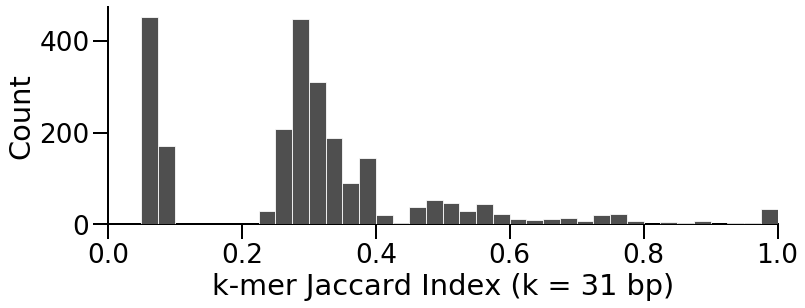

In [71]:
fig, ax1 = plt.subplots(figsize=(12,4))

#sns.set_style(None)
#sns.set()

ax1.grid(axis='y', zorder=0, linewidth=.7, color = "white" )
sns.set_style(rc={'axes.facecolor': '#E8E8E8'})

sns.histplot(LR_JaccSim_Pairwise_DF["Mash_JS"], bins = np.arange(0, 1.05, 0.025), edgecolor='white', color = '#4F4F4F', alpha = 1, ax = ax1, zorder = 3)
             # hist_kws={"rwidth":0.75,'edgecolor':'none', 'alpha':1.0})
sns.despine()

#ax1.set_axisbelow(True)


#plt.title("Distr. of pair-wise predicted ANI \n (158 Mtb isolates) ")

plt.xlabel("k-mer Jaccard Index (k = 31 bp)")
#plt.ylabel("# of genome pairs")
plt.ylabel("Count")
plt.xlim(0, 1.00)

ticks_ax_limewidth = 2

ax1.tick_params('both', length=15, width=ticks_ax_limewidth, which='major')

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(ticks_ax_limewidth)

#plt.tight_layout()



plt.savefig("Results5_Plots/6.Ecoli50CI.KmerJS.Histo.png", dpi = 300)
plt.savefig("Results5_Plots/6.Ecoli50CI.KmerJS.Histo.svg")
plt.show()


In [72]:
LR_JaccSim_Pairwise_DF.query("Mash_JS == 1")

,SampleID_1,SampleID_2,Mash_JS


## Make a HeatMap of Jaccard Simularity between assemblies

In [73]:
#OrderOfSampleIDs_Phylo

In [74]:
# Reorder the matrix of Jaccard Sim between all assemblies to fit phylogeny

AvA_LR_JS_Ordered_DF = AvA_LR_JS_DF.loc[OrderOfSampleIDs_Phylo, OrderOfSampleIDs_Phylo]
AvA_LR_JS_Ordered_DF.shape

(50, 50)

#### Make sample lineage & color mapping

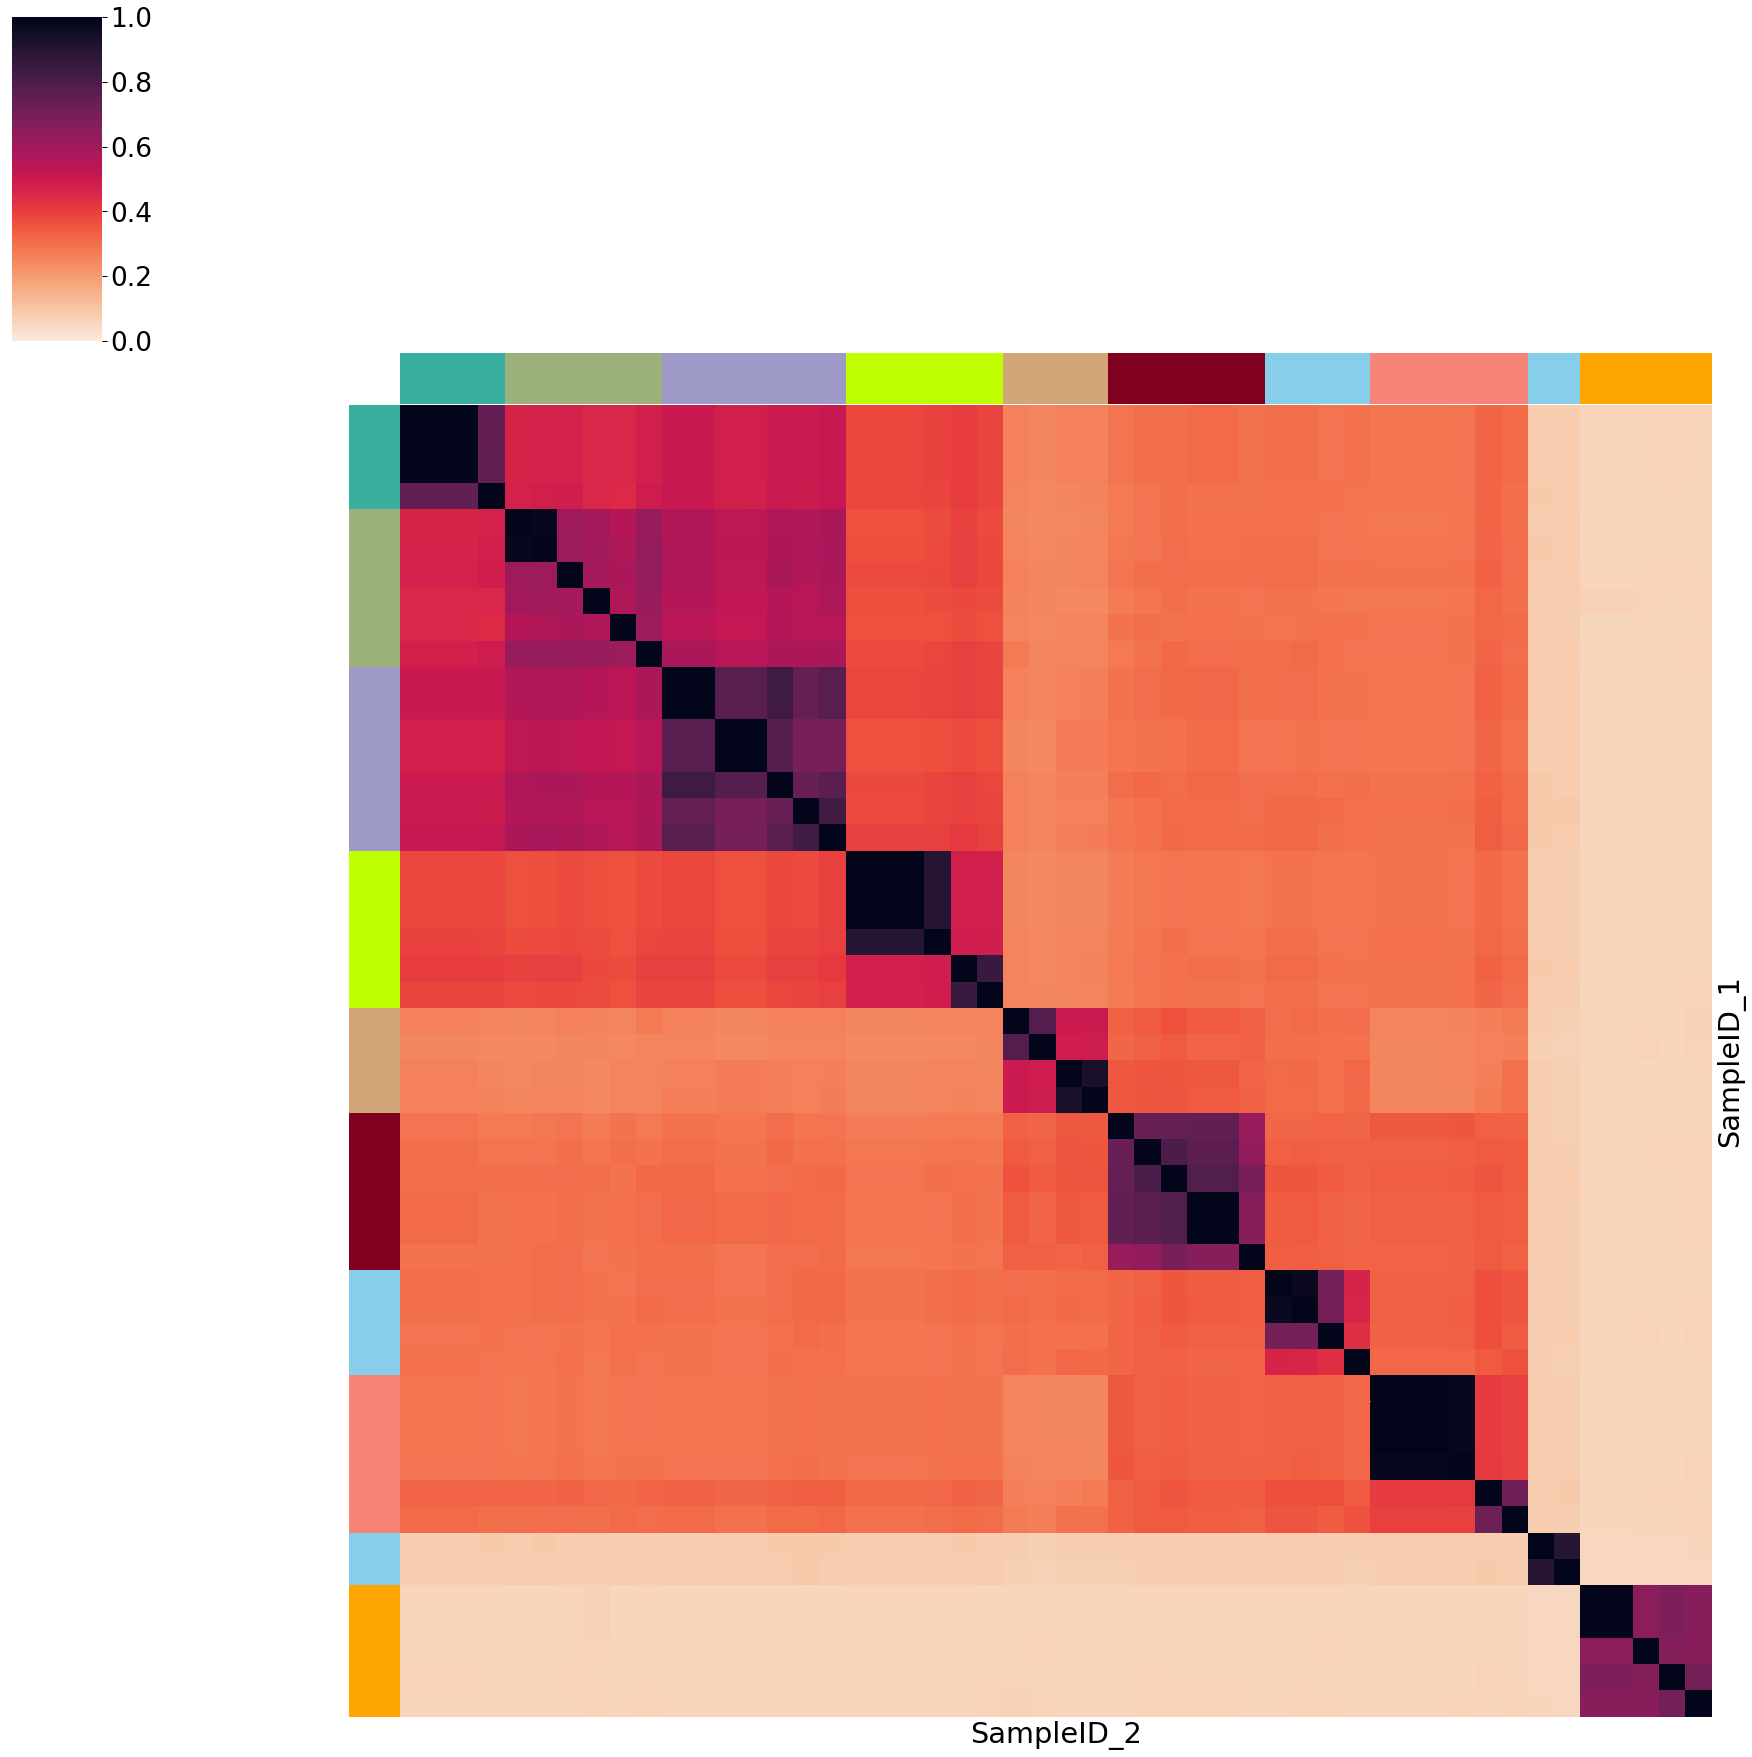

In [75]:
fig_dims = (25, 25)

row_colors = [sample_colors.get(sample, "black") for sample in AvA_LR_JS_Ordered_DF.index]
col_colors = [sample_colors.get(sample, "black") for sample in AvA_LR_JS_Ordered_DF.columns]

clustermap_plot = sns.clustermap(AvA_LR_JS_Ordered_DF, 
                                 row_colors=row_colors,
                                 col_colors=col_colors,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 #cbar_pos = None,
                                 cmap='rocket_r',
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False, vmin = 0 )

plt.ylabel("")
plt.xlabel("")

plt.savefig("Results5_Plots/6.Ecoli50CI.KmerJS.heatmap.NoLabels.png", dpi = 300)
plt.savefig("Results5_Plots/6.Ecoli50CI.KmerJS.heatmap.NoLabels.svg")
plt.show()

# Parse FastANI output (All vs All)

In [76]:
FastANI_MainDir = f"{target_SMK_OutputDir}/FastANI"

LR_Asm_AllVsAll_OutDir = f"{FastANI_MainDir}/FastANI_LRAsm"

AvA_158CI_FastANI_LRAsm_TXT = f"{LR_Asm_AllVsAll_OutDir}/FastANI.AllVsAll.LRAsm.txt"

#AvA_158CIWiH37Rv_FastANI_LRAsm_TXT = f"{LR_Asm_AllVsAll_OutDir}/FastANI.AllVsAll.WiH37Rv.LRAsm.txt"     



In [77]:
!ls -lah $LR_Asm_AllVsAll_OutDir

total 200K
drwxrwsr-x 2 mm774 farhat    44 Oct 12 02:24 .
drwxrwsr-x 4 mm774 farhat    63 Oct 12 02:14 ..
-rw-rw-r-- 1 mm774 farhat 1006K Oct 12 02:25 FastANI.AllVsAll.LRAsm.txt


In [78]:
FANI_AvA_DF = pd.read_csv(AvA_158CI_FastANI_LRAsm_TXT, sep = "\t", header = None)
FANI_AvA_DF.columns = ["Query", "Ref", "ANI", "Bidirect_FragMap", "Total_Query_Frags"]

# Trim down full file path to JUST the SampleID (For Query and Reference genomes)
FANI_AvA_DF["Query"] = FANI_AvA_DF["Query"].str.split("/").str[-1].str.split(".").str[0]
FANI_AvA_DF["Ref"] = FANI_AvA_DF["Ref"].str.split("/").str[-1].str.split(".").str[0]

FANI_AvA_DF.shape

(2500, 5)

In [79]:
FANI_AvA_DF.head(2)

,Query,Ref,ANI,Bidirect_FragMap,Total_Query_Frags
0,GCA_014109125,GCA_014109125,100.0000,1648,1650
1,GCA_014109125,GCA_013923405,99.9987,1646,1650


In [80]:
FANI_AvA_NoSelf_DF = FANI_AvA_DF.query(" Query != Ref ")
FANI_AvA_NoSelf_DF.shape

(2450, 5)

In [81]:
FANI_AvA_NoSelf_DF["ANI"].describe()

count    2450.000000
mean       95.996657
std         2.756381
min        90.635900
25%        92.439350
50%        97.067500
75%        97.560875
max        99.999800
Name: ANI, dtype: float64

In [82]:
FANI_AvA_NoSelf_DF.head(2)

,Query,Ref,ANI,Bidirect_FragMap,Total_Query_Frags
1,GCA_014109125,GCA_013923405,99.9987,1646,1650
2,GCA_014109125,GCA_014109065,99.9982,1646,1650


In [83]:
#FANI_AvA_Ordered_DF = FANI_AvA_DF.loc[OrderOfSampleIDs_Phylo, OrderOfSampleIDs_Phylo]
#FANI_AvA_Ordered_DF.shape

In [84]:
FANI_AvA_NoSelf_DF.sort_values("ANI", ascending=True).head(15)

,Query,Ref,ANI,Bidirect_FragMap,Total_Query_Frags
1299,GCA_013732895,GCA_013894235,90.6359,1243,1692
1199,GCA_013746655,GCA_013894235,90.6433,1242,1696
2149,GCA_013894235,GCA_013732895,90.6601,1239,1452
2148,GCA_013894235,GCA_013745515,90.6869,1237,1452
1149,GCA_014103465,GCA_013894235,90.6908,1239,1639
1148,GCA_014103465,GCA_013817505,90.7017,1232,1639
1298,GCA_013732895,GCA_013817505,90.7159,1238,1692
2147,GCA_013894235,GCA_013746655,90.7361,1236,1452
2146,GCA_013894235,GCA_014103665,90.7450,1217,1452
2145,GCA_013894235,GCA_014103465,90.7452,1239,1452


In [85]:
ID_To_Lineage_Dict["GCA_013745515"]

'cladeV'

In [86]:
ID_To_Lineage_Dict["GCA_014103665"]

'cladeV'

In [87]:
ID_To_Lineage_Dict["GCA_013894235"]

'F'

#### output parsed FastANI results to TSV

In [88]:
GenomeSim_OutDir = "../../Data/GenomeSimilarity_MtbAndEcoli"
!mkdir $GenomeSim_OutDir

mkdir: cannot create directory ‘../../Data/GenomeSimilarity_MtbAndEcoli’: File exists


In [89]:
FANI_AvA_Mtb_TSV = f"{GenomeSim_OutDir}/FastANI.Stats.Ecoli50CI.tsv"

FANI_AvA_DF.to_csv(FANI_AvA_Mtb_TSV, sep = "\t", index=False)

In [91]:
!ls -1 $GenomeSim_OutDir

FastANI.Stats.Ecoli50CI.tsv
FastANI.Stats.Mtb151CI.tsv
Sourmash.31merJaccardSim.Stats.Ecoli50CI.tsv
Sourmash.31merJaccardSim.Stats.Mtb151CI.tsv


# Plot the distribution of pairwise predicted ANIs 

In [85]:
FANI_AvA_NoSelf_DF["ANI"].describe()

count    2450.000000
mean       95.996657
std         2.756381
min        90.635900
25%        92.439350
50%        97.067500
75%        97.560875
max        99.999800
Name: ANI, dtype: float64

In [86]:
sns.set_context("paper", font_scale=3)


In [87]:
FANI_AvA_NoSelf_DF["ANI"].describe()

count    2450.000000
mean       95.996657
std         2.756381
min        90.635900
25%        92.439350
50%        97.067500
75%        97.560875
max        99.999800
Name: ANI, dtype: float64

In [88]:
sns.set_context("paper", font_scale=3)


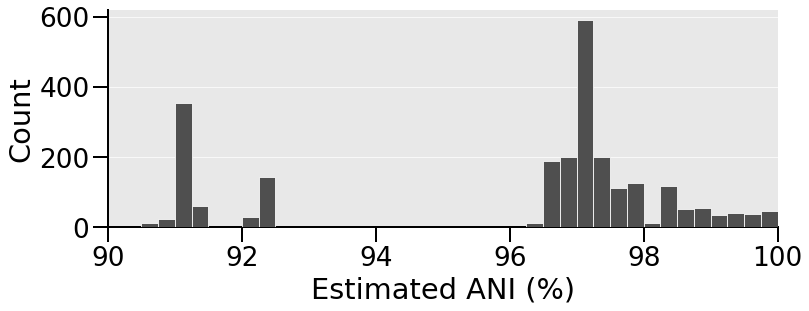

In [89]:
fig, ax1 = plt.subplots(figsize=(12,4))

#sns.set_style(None)
#sns.set()

ax1.grid(axis='y', zorder=0, linewidth=.7, color = "white" )
sns.set_style(rc={'axes.facecolor': '#E8E8E8'})

sns.histplot(FANI_AvA_NoSelf_DF["ANI"],  bins = np.arange(90, 101, 0.25),
             edgecolor='white', color = '#4F4F4F',
             alpha = 1, ax = ax1, zorder = 3)

sns.despine()

plt.xlabel("Estimated ANI (%)")
plt.ylabel("Count")
plt.xlim(90, 100)

ticks_ax_limewidth = 2
ax1.tick_params('both', length=15, width=ticks_ax_limewidth, which='major')

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(ticks_ax_limewidth)

plt.savefig("Results5_Plots/6.Ecoli50CI.ANI.Histo.png", dpi = 300)
plt.savefig("Results5_Plots/6.Ecoli50CI.ANI.Histo.svg")

plt.show()


In [90]:
FANI_AvA_DF.head()

,Query,Ref,ANI,Bidirect_FragMap,Total_Query_Frags
0,GCA_014109125,GCA_014109125,100.0000,1648,1650
1,GCA_014109125,GCA_013923405,99.9987,1646,1650
2,GCA_014109125,GCA_014109065,99.9982,1646,1650
3,GCA_014109125,GCA_013821965,99.4979,1482,1650
4,GCA_014109125,GCA_013750375,98.4922,1447,1650


In [91]:
FANI_AvA_DF["ANI"].describe()

count    2500.000000
mean       96.076723
std         2.785654
min        90.635900
25%        96.471000
50%        97.077050
75%        97.674525
max       100.000000
Name: ANI, dtype: float64

In [92]:
FANI_AvA_Pivot = FANI_AvA_DF.pivot(index='Query', columns='Ref', values='ANI')
FANI_AvA_Pivot.shape

(50, 50)

In [93]:
FANI_AvA_Pivot.head(2)

Ref,GCA_013602835,GCA_013712565,GCA_013713325,GCA_013728735,GCA_013732895,GCA_013745515,GCA_013746655,GCA_013750375,GCA_013752075,GCA_013752295,...,GCA_013899665,GCA_013900245,GCA_013923405,GCA_013924285,GCA_013928845,GCA_014103195,GCA_014103465,GCA_014103665,GCA_014109065,GCA_014109125
Query,,,,,,,,,,,,,,,,,,,,,
GCA_013602835,100.0000,97.0124,97.0169,97.4333,91.0448,91.1979,91.1118,97.1085,96.9546,97.0905,...,97.1823,97.2823,97.0678,97.2269,97.2335,99.0782,91.0525,91.1581,97.0600,97.0620
GCA_013712565,97.0085,100.0000,99.9996,97.1395,90.9226,91.0658,91.0005,99.4074,98.6550,99.3682,...,98.7837,97.0398,98.4176,96.5898,96.6453,97.0217,91.0429,91.1236,98.4108,98.4013


In [94]:

FANI_AvA_Pivot_Ordered = FANI_AvA_Pivot.loc[OrderOfSampleIDs_Phylo, OrderOfSampleIDs_Phylo]
FANI_AvA_Pivot_Ordered.shape

(50, 50)

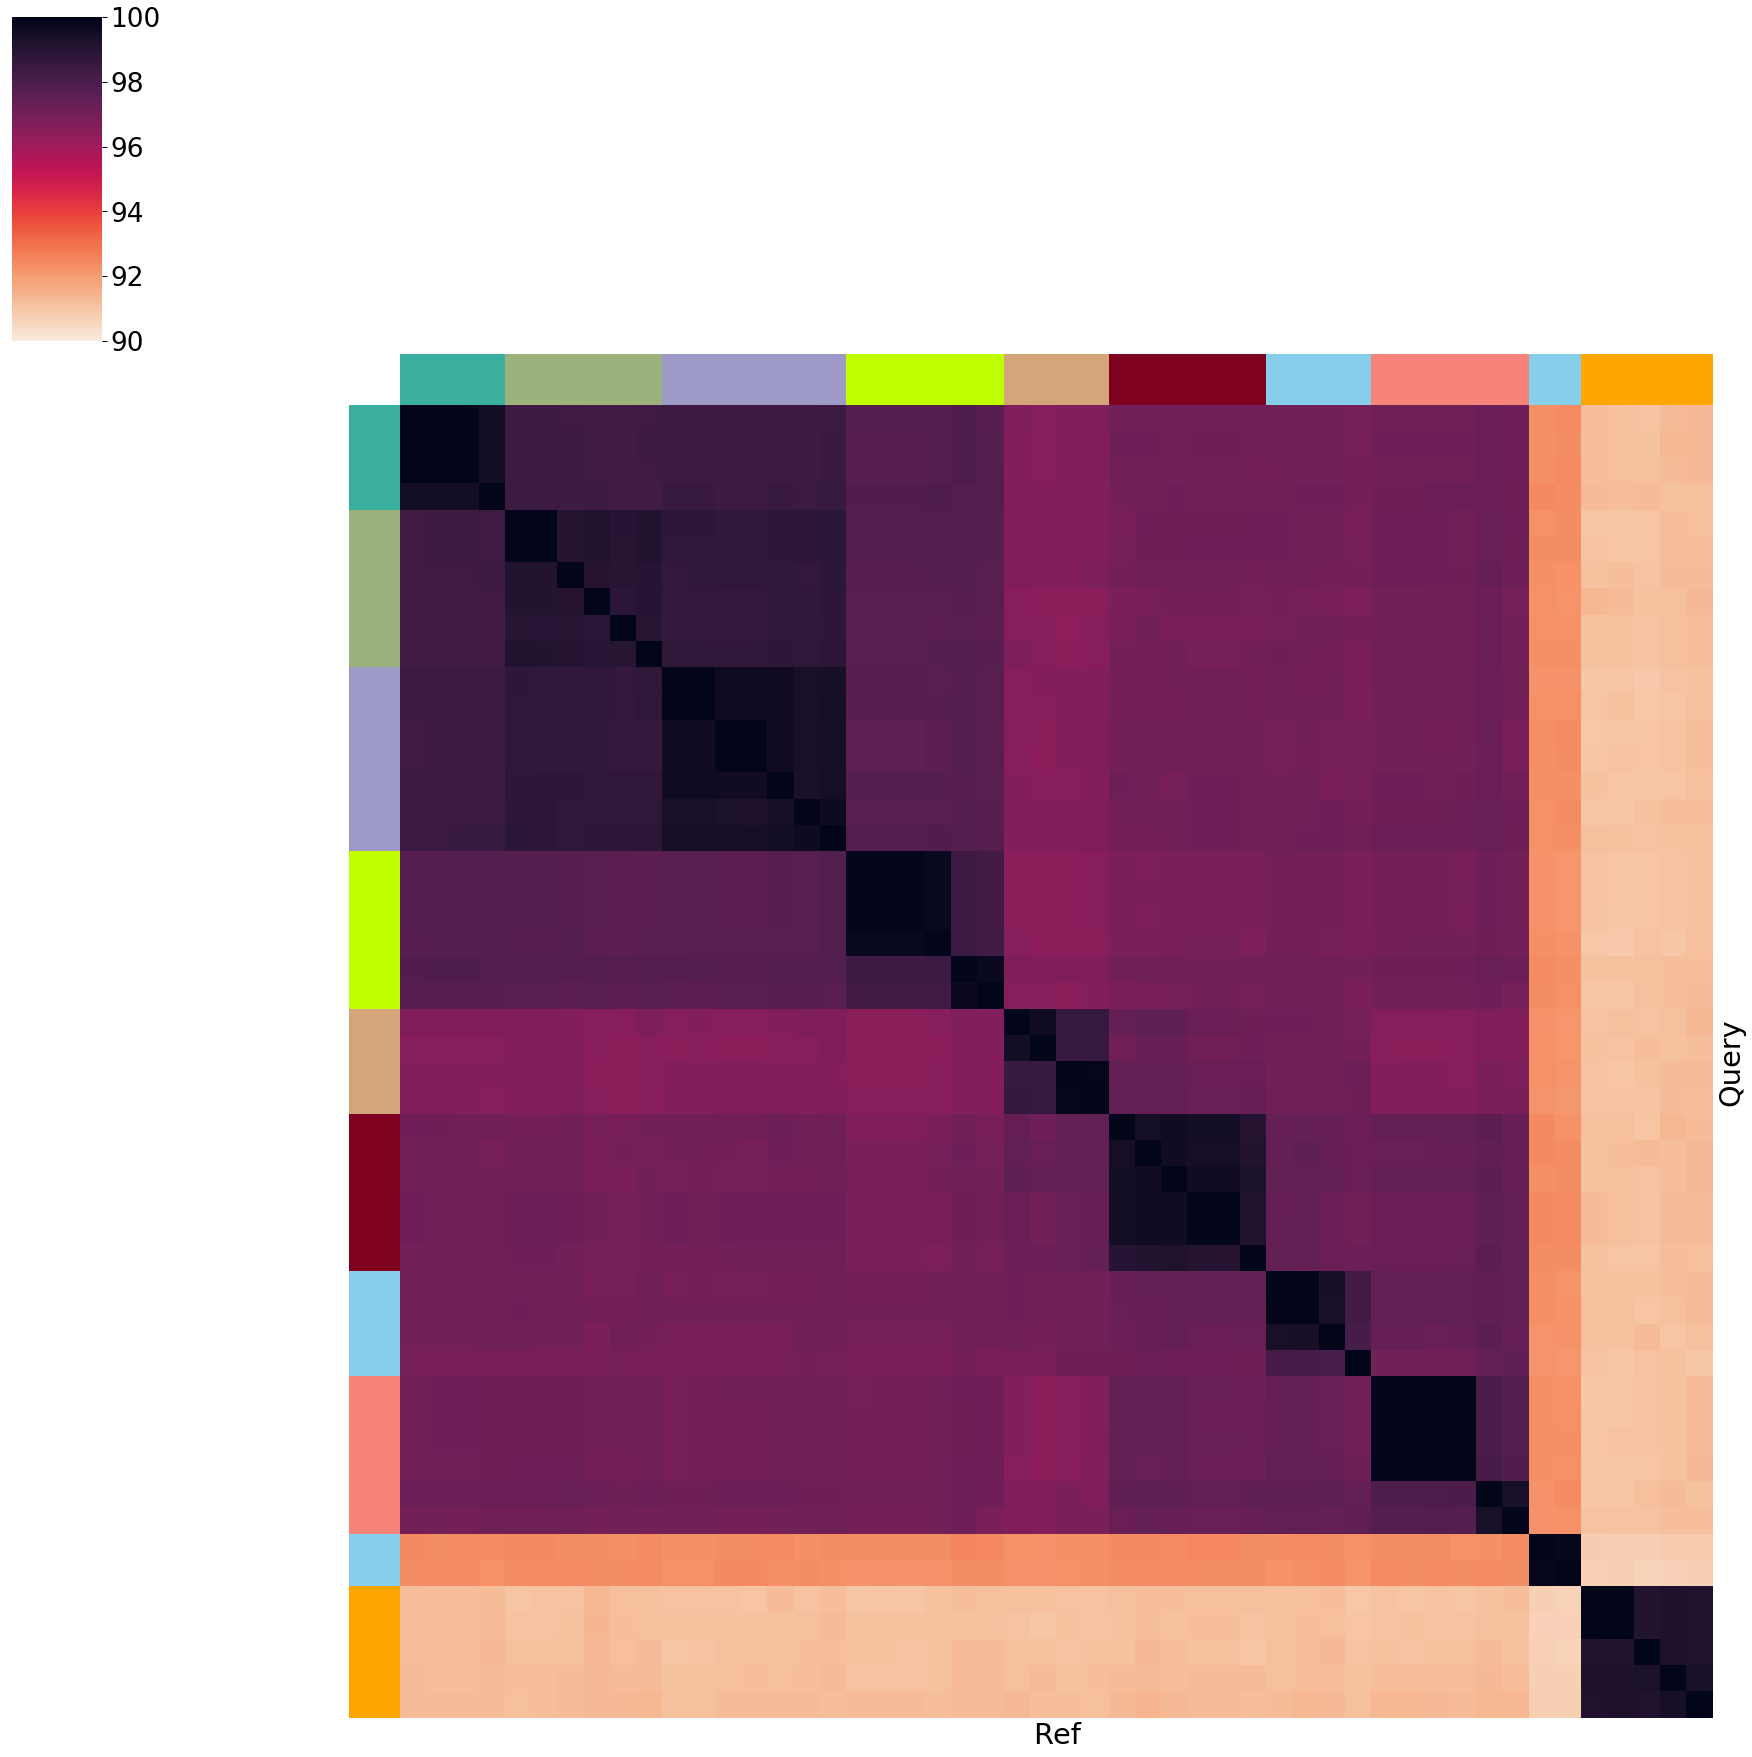

In [95]:
fig_dims = (25, 25)

row_colors = [sample_colors.get(sample, "black") for sample in FANI_AvA_Pivot_Ordered.index]
col_colors = [sample_colors.get(sample, "black") for sample in FANI_AvA_Pivot_Ordered.columns]

g = clustermap_plot = sns.clustermap(FANI_AvA_Pivot_Ordered, 
                                 row_colors=row_colors,
                                 col_colors=col_colors,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 #cbar_pos = None,
                                 cmap='rocket_r',
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False, vmin = 90 )


plt.ylabel("")
plt.xlabel("")

plt.savefig("Results5_Plots/6.Ecoli50CI.ANI.heatmap.NoLabels.png", dpi = 300)
plt.savefig("Results5_Plots/6.Ecoli50CI.ANI.heatmap.NoLabels.svg")

plt.show()